In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy
from datetime import datetime,timedelta
from xmovie import Movie
import nfft
import xrft

%matplotlib inline

# Parcels

In [2]:
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile
import math
from operator import attrgetter

In [21]:
filenames = {'U': "/Users/2311043/Documents/TOROS_U_0315.nc",
             'V': "/Users/2311043/Documents/TOROS_V_0315.nc"}
variables = {'U': 'u',
             'V': 'v'}
dimensions = {'lat': 'lat',
              'lon': 'lon',
              'time': 'time'}
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

In [22]:
# pset = ParticleSet.from_list(fieldset=fieldset, pclass=JITParticle,
#                              lon = velocity.lon[10,5:20].data,
#                              lat = velocity.lat[10,5:20].data)  # releasing on a line: the end longitude and latitude

pset = ParticleSet.from_line(fieldset=fieldset, pclass=JITParticle,
                             size=10,
                            start=[119.65,23.65],
                            finish=[120.1,23.65],
                            time=datetime(2015,3,15,0,0,0))  # releasing on a line: the end longitude and latitude

In [23]:
output_file = pset.ParticleFile(name="/Users/2311043/Documents/TOROS_Parcels/toros_forward.zarr", outputdt=timedelta(hours=1))
pset.execute(AdvectionRK4,
             runtime=timedelta(days=15),
             dt=timedelta(minutes=5),
             output_file=output_file)

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> C:\Users\2311043\AppData\Local\Temp\parcels-tmp\lib7faa6448ca6db415d61b94afe5fe8323_0.dll
INFO: Output files are stored in /Users/2311043/Documents/TOROS_Parcels/toros_forward.zarr.
100%|██████████| 1296000.0/1296000.0 [00:10<00:00, 118947.03it/s]


In [31]:
output_file = pset.ParticleFile(name="/Users/2311043/Documents/TOROS_Parcels/toros_backward.zarr", outputdt=timedelta(hours=1))
pset.execute(AdvectionRK4,
             endtime=datetime(2015,3,1,0,0,0),
             dt=-timedelta(minutes=5),
             output_file=output_file)

INFO: Output files are stored in /Users/2311043/Documents/TOROS_Parcels/toros_backward.zarr.
100%|██████████| 1209600.0/1209600.0 [00:08<00:00, 137051.90it/s]


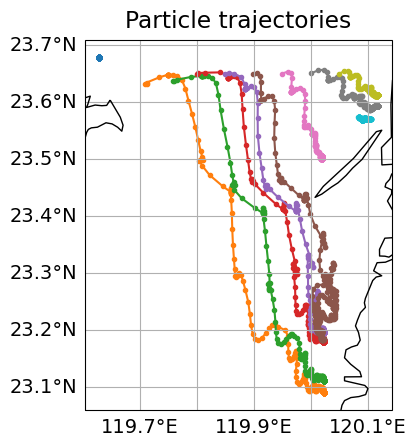

<module 'matplotlib.pyplot' from 'C:\\Users\\2311043\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [32]:
plotTrajectoriesFile("/Users/2311043/Documents/TOROS_Parcels/toros_backward.zarr")

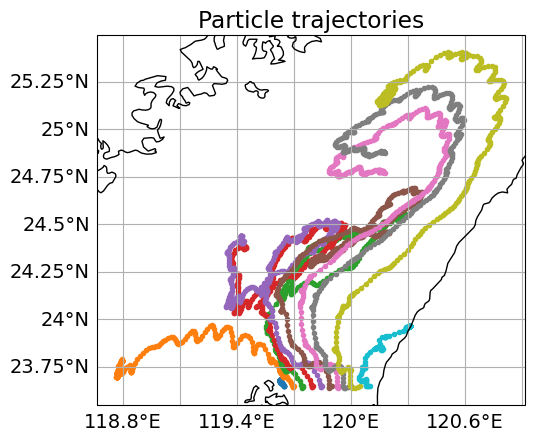

<module 'matplotlib.pyplot' from 'C:\\Users\\2311043\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [29]:
plotTrajectoriesFile("/Users/2311043/Documents/TOROS_Parcels/toros_forward.zarr")

In [40]:
data = xr.open_zarr("/Users/2311043/Documents/TOROS_Parcels/toros_forward.zarr").load()
data_filtered = xr.open_zarr("/Users/2311043/Documents/TOROS_Parcels/toros_backward.zarr").load()

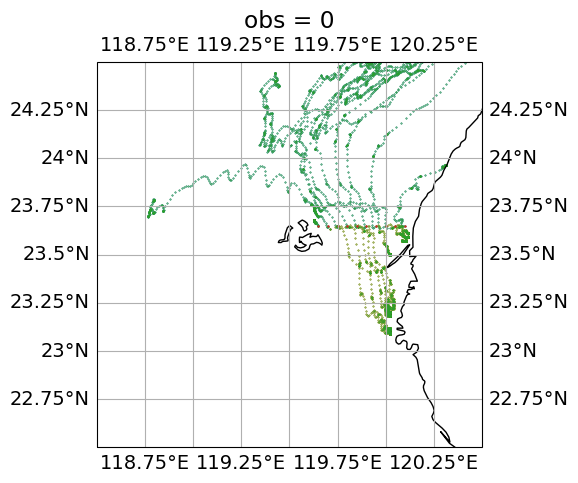

In [47]:
fig,(ax1) = plt.subplots(1,1,figsize=(5,5),subplot_kw={'projection':ccrs.PlateCarree()})
ax1.set_extent([118.5,120.5,22.5,24.5])
xr.plot.scatter(data,x='lon',y='lat',transform=ccrs.PlateCarree(),s=0.1)
xr.plot.scatter(data_filtered,x='lon',y='lat',transform=ccrs.PlateCarree(),s=0.1)
xr.plot.scatter(test,x='lon',y='lat',transform=ccrs.PlateCarree(),s=0.1)

xr.plot.scatter(data.isel(obs=0),x='lon',y='lat',transform=ccrs.PlateCarree(),s=0.5)
ax1.coastlines()
ax1.gridlines(draw_labels=True)

In [48]:
test = xr.concat((data_filtered,data),dim='obs').assign_coords({'obs':np.arange(0,698)})

In [49]:
test

<xarray.Dataset>
Dimensions:     (trajectory: 10, obs: 698)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 ... 690 691 692 693 694 695 696 697
  * trajectory  (trajectory) int64 40 41 42 43 44 45 46 47 48 49
Data variables:
    lat         (trajectory, obs) float32 23.68 23.68 23.68 ... 23.96 23.96
    lon         (trajectory, obs) float32 119.6 119.6 119.6 ... 120.3 120.3
    time        (trajectory, obs) datetime64[ns] 2015-03-15 ... 2015-03-30
    z           (trajectory, obs) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.1